In [1]:
import numpy as np
from prettytable import PrettyTable
import matplotlib.pyplot as plt
from scipy.stats import norm

#set seed
np.random.seed(4)

# General supporting functions

## Data sampling functions

In [2]:
#Sample the linear model, by first sampling the mean from a Redamacher distribution, and then sampling the model from a normal distribution around the mean
# dim: the dimension of the data (+ 1 for the constant 1)
# sigma: the standard deviation of the normal distribution
# bias_factor: the scale of the Redamacher distribution
def sample_model(dim, sigma, bias_factor):
    mean = (np.random.binomial(1, 0.5, dim+1)*2 - 1)*bias_factor
    return np.random.normal(mean, sigma)

#Sample the data, by sampling from a normal distribution with mean zero and the given standard deviation, and add the constant 1
# dim: the dimension of the data
# data_scale: the standard deviation of the normal distribution
# num_samples: the number of samples
def sample_data(dim, data_scale, num_samples):
    mean = np.zeros(dim)
    data = np.random.normal(mean, data_scale, (num_samples, dim))
    data = np.append(data, np.ones((data.shape[0], 1)), axis=1)
    return data

#Sample the labels, by first computing the probability of the positive class according to the logistic distribution, and then sampling from a Bernoulli distribution with the corresponding probability
# data: the data
# model: the linear model of the logistic distribution
def sample_labels(data, model):
    prob = 1/(1+np.exp(-np.dot(data, model)))
    labels = np.random.binomial(1, prob)
    return labels

#Sample the data, a model, and the labels using the above functions
def sample_training_set(data_parameters):
    model = sample_model(data_parameters['dim'], data_parameters['init_sigma'], data_parameters['bias_factor'])
    
    training_data = sample_data(data_parameters['dim'], data_parameters['data_scale'], data_parameters['training_sample_size'])
    training_labels = sample_labels(training_data, model)
    training_set = {'data': training_data, 'labels': training_labels}

    return training_set, model

#Sample the data, a model, and the labels for training and test sets using the above functions
def sample_train_and_test(data_parameters):
    model = sample_model(data_parameters['dim'], data_parameters['init_sigma'], data_parameters['bias_factor'])
    
    training_data = sample_data(data_parameters['dim'], data_parameters['data_scale'], data_parameters['training_sample_size'])
    training_labels = sample_labels(training_data, model)
    training_set = {'data': training_data, 'labels': training_labels}

    test_sample_size = int(data_parameters['training_sample_size'] * data_parameters['test_ratio'])
    test_data = sample_data(data_parameters['dim'], data_parameters['data_scale'], test_sample_size)
    test_labels = sample_labels(test_data, model)
    test_set = {'data': test_data, 'labels': test_labels}
    
    full_data = {'training': training_set, 'test': test_set}
    return full_data, model

## Logistic regression functions

In [3]:
#Compute the logistic loss of the given model on the given data set
# data_set: a dictionary containing the data and labels
# model: the linear model of the logistic distribution
def logistic_loss(data_set, model):
    #clip the probability to avoid numerical instability
    prob = np.clip(1/(1+np.exp(-np.dot(data_set['data'], model))), 1e-4, 1-1e-4)
    return -np.mean(data_set['labels'] * np.log(prob) + (1-data_set['labels']) * np.log(1-prob))

# Compute the logistic model from a given data set using gradient descent
# starting_model: the initial model
# data_set: a dictionary containing the data and labels
# learning_parameters: a dictionary containing the learning parameters
def logistic_regression(starting_model, data_set, learning_parameters):
    models = []
    last_model = starting_model.copy()
    models.append(last_model)
    for i in range(learning_parameters['num_of_iterations']):
        prob = np.clip(1/(1+np.exp(-np.dot(data_set['data'], last_model))), 1e-6, 1-1e-6)
        full_gradient = data_set['data'] * (data_set['labels'] - prob)[:, np.newaxis]
        if 'clipping_radius' in learning_parameters:
            gradient_norms = np.linalg.norm(full_gradient, axis=1)
            clipped_gradient_norms = np.minimum(np.linalg.norm(full_gradient, axis=1), learning_parameters['clipping_radius'])
            clipped_gradients = full_gradient * (clipped_gradient_norms / gradient_norms)[:, np.newaxis]
        else:
            clipped_gradients = full_gradient
        gradient = np.mean(clipped_gradients, axis=0)
        if 'noise_factor' in learning_parameters:
            gradient += np.random.normal(np.zeros_like(gradient) , learning_parameters['noise_factor'])
        last_model += learning_parameters['learning_rate'] * gradient
        models.append(last_model.copy())
    return np.array(models)

## Privacy calculation

In [4]:
# Compute the RDP factor for a sequence of noisy gradient descent steps
# num_of_iterations: the number of iterations
# noise_factor: the standard deviation of the noise
# clipping_radius: the clipping radius
# sample_size: the number of samples
def RDP_factor(num_of_iterations, noise_factor, clipping_radius, sample_size):
    return num_of_iterations * clipping_radius**2 / (2 *sample_size**2 * noise_factor**2)

# Compute the epsilon privacy parameter for a given delta using the RDP factor
# num_of_iterations: the number of iterations
# noise_factor: the standard deviation of the noise
# clipping_radius: the clipping radius
# sample_size: the number of samples
def epsilon_from_delta(num_of_iterations, noise_factor, clipping_radius, sample_size, delta):
    rho = RDP_factor(num_of_iterations, noise_factor, clipping_radius, sample_size)
    return rho + 2 * np.sqrt(rho * np.log(np.sqrt(np.pi * rho)/delta))

# Compute the delta privacy parameter for a given epsilon using the RDP factor
# num_of_iterations: the number of iterations
# noise_factor: the standard deviation of the noise
# clipping_radius: the clipping radius
# sample_size: the number of samples
def delta_from_epsilon(num_of_iterations, noise_factor, clipping_radius, sample_size, epsilon):
    rho = RDP_factor(num_of_iterations, noise_factor, clipping_radius, sample_size)
    if rho >= epsilon:
        return 1
    factor = (epsilon-rho) / (2*rho)
    return 2*np.exp(-rho*factor**2 ) / (1+factor+np.sqrt((1+factor)**2+4/(np.pi*rho)))

# 1. Accuracy simulation infrastructure

## Supporting object

In [5]:
# A class to store the losses of different models
class Losses:

    def __init__(self, name):
        self.name = name
        self.loss = {}
    
    def __init__(self, name, data_set = [], models = []):
        self.name = name
        self.loss = {}
        for key in models:
            self.loss[key + ' model'] = logistic_loss(data_set, models[key])

    def add_loss(self, other):
        for key in other.loss:
            if key in self.loss:
                self.loss[key] += other.loss[key]
            else:
                self.loss[key] = other.loss[key]

    def average_loss(self, num_of_experiments):
        for key in self.loss:
            self.loss[key] /= num_of_experiments

## Experiment functions

In [6]:
# A single experiment, which samples the data and the model, and then computes the losses of the true model, the guess model, and the learned models, one per learning_parameters
# data_parameters: a dictionary containing the data sampling parameters
# learning_parameters_array: an array of dictionaries, each containing a set of learning parameters
def run_experiment(data_parameters, learning_parameters_array):
    full_data, true_model = sample_train_and_test(data_parameters)
    guess_model = sample_model(data_parameters['dim'], data_parameters['init_sigma'], data_parameters['bias_factor'])
    models = {'true': true_model, 'guess': guess_model}
    for i in range(len(learning_parameters_array)):
        models_array = logistic_regression(guess_model, full_data['training'], learning_parameters_array[i])
        model = models_array[-1]
        models[(learning_parameters_array[i])['name']] = model
    training_losses = Losses('training', full_data['training'], models)
    test_losses = Losses('test', full_data['test'], models)
    return training_losses, test_losses

# A full experiment, which runs num_of_experiments experiments using the previous function and averages the losses
# data_parameters: a dictionary containing the data sampling parameters
# learning_parameters_array: an array of dictionaries, each containing a set of learning parameters
# num_of_experiments: the number of experiments
def run_full_experiment(data_parameters, learning_parameters_array, num_of_experiments):
    training_losses = Losses('training')
    test_losses = Losses('test')

    for i in range(num_of_experiments):
        iter_training_losses, iter_test_losses = run_experiment(data_parameters, learning_parameters_array)
        training_losses.add_loss(iter_training_losses)
        test_losses.add_loss(iter_test_losses)

    training_losses.average_loss(num_of_experiments)
    test_losses.average_loss(num_of_experiments)            
    return training_losses, test_losses

## Output function

In [7]:
def float2txt(num):
    return "{:.3f}".format(num)

#Print the results of the accuracy experiment
# data_parameters: a dictionary containing the data sampling parameters
# training_losses: the losses on the training set
# test_losses: the losses on the test set
def print_results(data_parameters, training_losses, test_losses):
    print('Losses for dim = ', str(data_parameters['dim']), ', data_scale = ', str(data_parameters['data_scale']), ', training_sample_size = ', str(data_parameters['training_sample_size']))
    
    table = PrettyTable(['model', 'Training', 'test'])
    for key in training_losses.loss:
        table.add_row([key, float2txt(training_losses.loss[key]), float2txt(test_losses.loss[key])])
    print(table)

## Experiment 1

In [8]:
data_parameters = {'dim': 10, 'data_scale': 2, 'init_sigma': 0.5, 'bias_factor': 1, 'training_sample_size': 300, 'test_ratio': 0.5}
learning_parameters = [{'name': 'Learned', 'learning_rate': 1, 'num_of_iterations': 40}]
num_of_experiments   = 1000

In [9]:
training_losses, test_losses = run_full_experiment(data_parameters, learning_parameters, num_of_experiments)
print_results(data_parameters, training_losses, test_losses)

Losses for dim =  10 , data_scale =  2 , training_sample_size =  300
+---------------+----------+-------+
|     model     | Training |  test |
+---------------+----------+-------+
|   true model  |  0.180   | 0.179 |
|  guess model  |  2.569   | 2.568 |
| Learned model |  0.170   | 0.199 |
+---------------+----------+-------+


# 2. Reconstruction attacks infrastructure

## Reconstruction functions

In [10]:
# Linear regression based reconstruction method of the form queries * rec = answers
# queries: the queries matrix
# answers: the answers vector
def lin_reg_reconstruction(queries, answers):
    rec = np.linalg.lstsq(queries, answers, rcond=None)[0]
    return np.rint(np.clip(rec, 0, 1))

# Extract the gradients from the intermediate models including the final model
# data: the dataset
# models_array: the array of intermediate models
# learning_rate: the learning rate
def extract_gradients_from_intermediate_models(data, models_array, learning_rate):
    sample_size = data.shape[0]
    queries = data.T
    answers = np.zeros(data.shape[1])
    num_models = models_array.shape[0]
    for i in range(num_models - 1):
        model_before = models_array[i]
        model_after = models_array[i+1]
        prob = np.clip(1/(1+np.exp(-np.dot(data, model_before))), 1e-6, 1-1e-6)
        gradient = (model_after - model_before) / learning_rate
        answers += np.dot(data.T, prob) + gradient*sample_size
    prob = np.clip(1/(1+np.exp(-np.dot(data, model_after))), 1e-6, 1-1e-6)
    answers += np.dot(data.T, prob)
    answers /= num_models
    return queries, answers

# Run the reconstruction test based on the intermediate models by first extracting the gradients and then running the linear regression based reconstruction
# data_set: the dataset
# models_array: the array of intermediate models
def reconstruction_test_for_intermediate_models(data_set, models_array, learning_rate):
    queries, answers = extract_gradients_from_intermediate_models(data_set['data'], models_array, learning_rate)
    reconstruction = lin_reg_reconstruction(queries, answers)
    return np.mean(np.abs(reconstruction - data_set['labels']))

# Extract the gradients from the final model
# data: the dataset
# model: the final model
def extract_gradients_from_final_model(data, model):
    queries = data.T
    prob = np.clip(1/(1+np.exp(-np.dot(data, model))), 1e-6, 1-1e-6)
    answers = np.dot(data.T, prob)
    return queries, answers

# Run the reconstruction test based on the final model by first extracting the gradient and then running the linear regression based reconstruction
# data_set: the dataset
# model: the final model
def reconstruction_test_for_final_models(data_set, model):
    queries, answers = extract_gradients_from_final_model(data_set['data'], model)
    reconstruction = lin_reg_reconstruction(queries, answers)
    return np.mean(np.abs(reconstruction - data_set['labels']))

## Supporting object

In [11]:
# A class to store the reconstruction errors of different models
class ReconstructionErrors:

    def __init__(self, keys):
        self.error = {}
        for key in keys:
            self.error[key] = 0
    
    def add_error(self, other):
        for key in other.error:
            self.error[key] += other.error[key]

    def average_error(self, num_of_experiments):
        for key in self.error:
            self.error[key] /= num_of_experiments

## Experiment functions

In [12]:
# A single reconstruction experiment, which samples the data and the model, and then computes the reconstruction errors of the intermediate models and the final model, one per learning_parameters
# data_parameters: a dictionary containing the data sampling parameters
# learning_parameters_array: an array of dictionaries, each containing a set of learning parameters
def run_reconstruction_experiment(data_parameters, learning_parameters_array):
    training_set, _ = sample_training_set(data_parameters)
    guess_model = sample_model(data_parameters['dim'], data_parameters['init_sigma'], data_parameters['bias_factor'])
    models = {}
    keys = [learning_parameters['name'] for learning_parameters in learning_parameters_array]
    intermediate_models_reconstruction_errors = ReconstructionErrors(keys)
    final_model_reconstruction_errors = ReconstructionErrors(keys)
    for i, key in enumerate(keys):
        learning_parameters = learning_parameters_array[i]
        models_array = logistic_regression(guess_model, training_set, learning_parameters)
        model = models_array[-1]
        models[key] = model
        intermediate_models_reconstruction_errors.error[key] = reconstruction_test_for_intermediate_models(training_set, models_array, learning_parameters['learning_rate'])
        final_model_reconstruction_errors.error[key] = reconstruction_test_for_final_models(training_set, model)
    return intermediate_models_reconstruction_errors, final_model_reconstruction_errors

# A full reconstruction experiment, which runs num_of_experiments experiments using the previous function and averages the reconstruction errors
# data_parameters: a dictionary containing the data sampling parameters
# learning_parameters_array: an array of dictionaries, each containing a set of learning parameters
def run_full_reconstruction_experiment(data_parameters, learning_parameters_array, num_of_experiments):
    keys = [learning_parameters['name'] for learning_parameters in learning_parameters_array]
    intermediate_models_reconstruction_errors = ReconstructionErrors(keys)
    final_model_reconstruction_errors = ReconstructionErrors(keys)

    for i in range(num_of_experiments):
        iter_intermediate_models_reconstruction_errors, iter_final_model_reconstruction_errors = run_reconstruction_experiment(data_parameters, learning_parameters_array)
        intermediate_models_reconstruction_errors.add_error(iter_intermediate_models_reconstruction_errors)
        final_model_reconstruction_errors.add_error(iter_final_model_reconstruction_errors)

    intermediate_models_reconstruction_errors.average_error(num_of_experiments)
    final_model_reconstruction_errors.average_error(num_of_experiments)
    return intermediate_models_reconstruction_errors, final_model_reconstruction_errors

## Output functions

In [13]:
#Print the results of the reconstruction experiment from intermidiate models
# data_parameters: a dictionary containing the data sampling parameters
# learning_parameters_array: an array of dictionaries, each containing a set of learning parameters
# intermediate_models_reconstruction_errors: the reconstruction errors of the intermediate models
def print_reconstruction_results_intermidiate(data_parameters, intermediate_models_reconstruction_errors):
    print('Reconstruction errors for dim = ', str(data_parameters['dim']), ', data_scale = ', str(data_parameters['data_scale']), ', training_sample_size = ', str(data_parameters['training_sample_size']))
    
    table = PrettyTable(['Model', 'Intermediate models '])
    for key in intermediate_models_reconstruction_errors.error:
        table.add_row([key, float2txt(intermediate_models_reconstruction_errors.error[key])])
    print(table)

#Print the results of the reconstruction experiment from intermidiate models and from the final model
# data_parameters: a dictionary containing the data sampling parameters
# learning_parameters_array: an array of dictionaries, each containing a set of learning parameters
# intermediate_models_reconstruction_errors: the reconstruction errors of the intermediate models
# final_model_reconstruction_errors: the reconstruction errors of the final model
def print_reconstruction_results_intermidiate_and_final(data_parameters, intermediate_models_reconstruction_errors, final_model_reconstruction_errors):
    print('Reconstruction errors for dim = ', str(data_parameters['dim']), ', data_scale = ', str(data_parameters['data_scale']), ', training_sample_size = ', str(data_parameters['training_sample_size']))
    
    table = PrettyTable(['Model', 'Intermediate models ', 'Final model'])
    for key in intermediate_models_reconstruction_errors.error:
        table.add_row([key, float2txt(intermediate_models_reconstruction_errors.error[key]), float2txt(final_model_reconstruction_errors.error[key])])
    print(table)

#Print the results of the reconstruction experiment from intermidiate models and from the final model, and the corresponding epsilon for a given delta
# data_parameters: a dictionary containing the data sampling parameters
# learning_parameters_array: an array of dictionaries, each containing a set of learning parameters
# intermediate_models_reconstruction_errors: the reconstruction errors of the intermediate models
# final_model_reconstruction_errors: the reconstruction errors of the final model
# delta: the delta privacy parameter
def print_reconstruction_results_with_epsilon(data_parameters, learning_parameters_array, intermediate_models_reconstruction_errors, final_model_reconstruction_errors, delta):
    print('Reconstruction errors for dim = ', str(data_parameters['dim']), ', data_scale = ', str(data_parameters['data_scale']), ', training_sample_size = ', str(data_parameters['training_sample_size']))
    print('epsilon computed for delta = ', str(delta))
    
    table = PrettyTable(['Model', 'epsilon', 'Intermediate models ', 'Final model'])
    for key in intermediate_models_reconstruction_errors.error:
        learning_parameters = learning_parameters_array[[learning_parameters['name'] for learning_parameters in learning_parameters_array].index(key)]
        if 'noise_factor' in learning_parameters:
            epsilon = epsilon_from_delta(learning_parameters['num_of_iterations'], learning_parameters['noise_factor'], learning_parameters['clipping_radius'], data_parameters['training_sample_size'], delta)
            epsilon_txt = float2txt(epsilon)
        else:
            epsilon_txt = 'inf'
        table.add_row([key, epsilon_txt, float2txt(intermediate_models_reconstruction_errors.error[key]), float2txt(final_model_reconstruction_errors.error[key])])
    print(table)

## Experiment 2.1

In [14]:
data_parameters = {'dim': 100, 'data_scale': 2, 'init_sigma': 1, 'bias_factor': 3, 'test_ratio': 0.5}
data_parameters['training_sample_size'] = data_parameters['dim']+1
learning_parameters_array = [{'name': 'Learned', 'learning_rate': 20, 'num_of_iterations': 20}, 
                       {'name': 'Learned - noisy (0.02)', 'learning_rate': 20, 'num_of_iterations': 20, 'clipping_radius': data_parameters['data_scale']*4, 'noise_factor': 0.02},
                       {'name': 'Learned - noisy (0.05)', 'learning_rate': 20, 'num_of_iterations': 20, 'clipping_radius': data_parameters['data_scale']*4, 'noise_factor': 0.05},
                       {'name': 'Learned - noisy (0.1)', 'learning_rate': 20, 'num_of_iterations': 20, 'clipping_radius': data_parameters['data_scale']*4, 'noise_factor': 0.1},
                       {'name': 'Learned - noisy (0.15)', 'learning_rate': 20, 'num_of_iterations': 20, 'clipping_radius': data_parameters['data_scale']*4, 'noise_factor': 0.15},
                       {'name': 'Learned - noisy (0.2)', 'learning_rate': 20, 'num_of_iterations': 20, 'clipping_radius': data_parameters['data_scale']*4, 'noise_factor': 0.2},
                       {'name': 'Learned - noisy (0.25)', 'learning_rate': 20, 'num_of_iterations': 20, 'clipping_radius': data_parameters['data_scale']*4, 'noise_factor': 0.25}]
num_of_experiments   = 1000

In [15]:
training_losses, test_losses = run_full_experiment(data_parameters, learning_parameters_array, num_of_experiments)
print_results(data_parameters, training_losses, test_losses)

intermediate_models_reconstruction_errors, final_model_reconstruction_errors = run_full_reconstruction_experiment(data_parameters, learning_parameters_array, num_of_experiments)
print_reconstruction_results_intermidiate(data_parameters, intermediate_models_reconstruction_errors)

/var/folders/ql/wp0qmxh5457dhfv74pc954hh0000gn/T/ipykernel_26432/3379327836.py:18: RuntimeWarning: overflow encountered in exp
  prob = np.clip(1/(1+np.exp(-np.dot(data_set['data'], last_model))), 1e-6, 1-1e-6)
/var/folders/ql/wp0qmxh5457dhfv74pc954hh0000gn/T/ipykernel_26432/3379327836.py:6: RuntimeWarning: overflow encountered in exp
  prob = np.clip(1/(1+np.exp(-np.dot(data_set['data'], model))), 1e-4, 1-1e-4)


Losses for dim =  100 , data_scale =  2 , training_sample_size =  101
+------------------------------+----------+-------+
|            model             | Training |  test |
+------------------------------+----------+-------+
|          true model          |  0.021   | 0.021 |
|         guess model          |  4.339   | 4.357 |
|        Learned model         |  0.000   | 2.595 |
| Learned - noisy (0.02) model |  0.064   | 2.855 |
| Learned - noisy (0.05) model |  0.350   | 2.988 |
| Learned - noisy (0.1) model  |  0.852   | 3.184 |
| Learned - noisy (0.15) model |  1.305   | 3.345 |
| Learned - noisy (0.2) model  |  1.633   | 3.476 |
| Learned - noisy (0.25) model |  1.952   | 3.598 |
+------------------------------+----------+-------+


/var/folders/ql/wp0qmxh5457dhfv74pc954hh0000gn/T/ipykernel_26432/3774633263.py:20: RuntimeWarning: overflow encountered in exp
  prob = np.clip(1/(1+np.exp(-np.dot(data, model_before))), 1e-6, 1-1e-6)
/var/folders/ql/wp0qmxh5457dhfv74pc954hh0000gn/T/ipykernel_26432/3774633263.py:23: RuntimeWarning: overflow encountered in exp
  prob = np.clip(1/(1+np.exp(-np.dot(data, model_after))), 1e-6, 1-1e-6)
/var/folders/ql/wp0qmxh5457dhfv74pc954hh0000gn/T/ipykernel_26432/3774633263.py:41: RuntimeWarning: overflow encountered in exp
  prob = np.clip(1/(1+np.exp(-np.dot(data, model))), 1e-6, 1-1e-6)


Reconstruction errors for dim =  100 , data_scale =  2 , training_sample_size =  101
+------------------------+----------------------+
|         Model          | Intermediate models  |
+------------------------+----------------------+
|        Learned         |        0.000         |
| Learned - noisy (0.02) |        0.000         |
| Learned - noisy (0.05) |        0.005         |
| Learned - noisy (0.1)  |        0.052         |
| Learned - noisy (0.15) |        0.107         |
| Learned - noisy (0.2)  |        0.158         |
| Learned - noisy (0.25) |        0.198         |
+------------------------+----------------------+


## Experiment 2.2

In [16]:
print_reconstruction_results_intermidiate_and_final(data_parameters, intermediate_models_reconstruction_errors, final_model_reconstruction_errors)

Reconstruction errors for dim =  100 , data_scale =  2 , training_sample_size =  101
+------------------------+----------------------+-------------+
|         Model          | Intermediate models  | Final model |
+------------------------+----------------------+-------------+
|        Learned         |        0.000         |    0.000    |
| Learned - noisy (0.02) |        0.000         |    0.014    |
| Learned - noisy (0.05) |        0.005         |    0.048    |
| Learned - noisy (0.1)  |        0.052         |    0.104    |
| Learned - noisy (0.15) |        0.107         |    0.148    |
| Learned - noisy (0.2)  |        0.158         |    0.184    |
| Learned - noisy (0.25) |        0.198         |    0.215    |
+------------------------+----------------------+-------------+


## Experiment 2.3

In [17]:
delta = 0.0001

In [18]:
print_reconstruction_results_with_epsilon(data_parameters, learning_parameters_array, intermediate_models_reconstruction_errors, final_model_reconstruction_errors, delta)

Reconstruction errors for dim =  100 , data_scale =  2 , training_sample_size =  101
epsilon computed for delta =  0.0001
+------------------------+---------+----------------------+-------------+
|         Model          | epsilon | Intermediate models  | Final model |
+------------------------+---------+----------------------+-------------+
|        Learned         |   inf   |        0.000         |    0.000    |
| Learned - noisy (0.02) | 244.730 |        0.000         |    0.014    |
| Learned - noisy (0.05) |  58.915 |        0.005         |    0.048    |
| Learned - noisy (0.1)  |  22.661 |        0.052         |    0.104    |
| Learned - noisy (0.15) |  13.504 |        0.107         |    0.148    |
| Learned - noisy (0.2)  |  9.492  |        0.158         |    0.184    |
| Learned - noisy (0.25) |  7.272  |        0.198         |    0.215    |
+------------------------+---------+----------------------+-------------+


# 3. Membership inference from final model

## Membership inference functions

In [19]:
# Extract the gradients from the final model based on the dataset
# data: the dataset
# model: the final model
# clipping_radius: the clipping radius
def gradient_from_data(data_set, model, clipping_radius):
    prob = np.clip(1/(1+np.exp(-np.dot(data_set['data'], model))), 1e-6, 1-1e-6)
    full_gradient = data_set['data'] * (data_set['labels'] - prob)[:, np.newaxis]
    gradient_norms = np.linalg.norm(full_gradient, axis=1)
    clipped_gradient_norms = np.minimum(np.linalg.norm(full_gradient, axis=1), clipping_radius)
    clipped_gradients = full_gradient * (clipped_gradient_norms / gradient_norms)[:, np.newaxis]
    return np.mean(clipped_gradients, axis=0)

# Membership inference test based on the gradients of the final model with respect to two datasets
# data_sets: an array of two datasets
# model: the final model
# clipping_radius: the clipping radius
def membership_inference_test(data_sets, model, clipping_radius):
    gradient_0 = gradient_from_data(data_sets[0], model, clipping_radius) * ((data_sets[1])['data']).shape[0]
    gradient_1 = gradient_from_data(data_sets[1], model, clipping_radius) * ((data_sets[1])['data']).shape[0]
    gradient_0_norm = np.linalg.norm(gradient_0)
    gradient_1_norm = np.linalg.norm(gradient_1)
    gradient_norm_diff = gradient_1_norm - gradient_0_norm
    return gradient_norm_diff


## Experiment functions

In [20]:
# Create two neighboring datasets by adding a sample that is perpendicular to the true model to the original dataset, and then label the sample with 0 and 1 respectively
# data_set: the original dataset
# true_model: the true model
# clipping_radius: the clipping radius
def create_neighboring_datasets(data_set, true_model, clipping_radius):
    sample_0 = true_model / np.linalg.norm(true_model) * clipping_radius
    data_0 = np.append(data_set['data'].copy(), sample_0[np.newaxis, :], axis=0)
    labels_0 = np.append(data_set['labels'].copy(), 0)
    sample_1 = sample_0.copy()
    data_1 = np.append(data_set['data'].copy(), sample_1[np.newaxis, :], axis=0)
    labels_1 = np.append(data_set['labels'].copy(), 1)
    correct_training_set = {'data': data_0, 'labels': labels_0}
    mislabel_training_set = {'data': data_1, 'labels': labels_1}
    return correct_training_set, mislabel_training_set

# A single membership inference experiment, which samples the data and the model, and then computes the membership inference test for the two neighboring datasets
# data_parameters: a dictionary containing the data sampling parameters
# learning_parameters_array: an array of dictionaries, each containing a set of learning parameters
def run_MI_experiment(data_parameters, learning_parameters_array):
    training_set, true_model = sample_training_set(data_parameters)
    guess_model = sample_model(data_parameters['dim'], data_parameters['init_sigma'], data_parameters['bias_factor'])
    keys = [learning_parameters['name'] for learning_parameters in learning_parameters_array]
    index = np.random.binomial(1, 0.5)
    gradient_norm_diffs = np.zeros(len(keys))
    for i in range(len(keys)):
        learning_parameters = learning_parameters_array[i]
        correct_training_set, mislabel_training_set = create_neighboring_datasets(training_set, true_model, learning_parameters['clipping_radius'])
        if index:
            training_sets = [correct_training_set, mislabel_training_set]
        else:
            training_sets = [mislabel_training_set, correct_training_set]
        models_array = logistic_regression(guess_model, correct_training_set, learning_parameters)
        model = models_array[-1]
        gradient_norm_diffs[i] = membership_inference_test(training_sets, model, learning_parameters['clipping_radius'])
    return index, gradient_norm_diffs

# A full membership inference experiment, which runs num_of_experiments experiments using the previous function and averages the membership inference tests
# data_parameters: a dictionary containing the data sampling parameters
# learning_parameters_array: an array of dictionaries, each containing a set of learning parameters
def run_full_MI_experiment(data_parameters, learning_parameters_array, num_of_experiments):
    keys = [learning_parameters['name'] for learning_parameters in learning_parameters_array]
    indeces = np.zeros(num_of_experiments)
    projections = np.zeros((num_of_experiments, len(keys)))
    for i in range(num_of_experiments):
        indeces[i], projections[i, :] = run_MI_experiment(data_parameters, learning_parameters_array)
    return indeces, projections

## Experiment 3

In [21]:
data_parameters = {'dim': 10, 'data_scale': 2, 'init_sigma': 1, 'bias_factor': 1, 'training_sample_size': 100, 'test_ratio': 0.5}
learning_parameters_array = [{'name': 'Learned - noisy (0.01)', 'learning_rate': 1, 'num_of_iterations': 100, 'clipping_radius': data_parameters['data_scale']*4, 'noise_factor': 0.1}]
num_of_experiments = 10000

In [22]:
training_losses, test_losses = run_full_experiment(data_parameters, learning_parameters_array, num_of_experiments)
print_results(data_parameters, training_losses, test_losses)

indeces, differences = run_full_MI_experiment(data_parameters, learning_parameters_array, num_of_experiments)

Losses for dim =  10 , data_scale =  2 , training_sample_size =  100
+------------------------------+----------+-------+
|            model             | Training |  test |
+------------------------------+----------+-------+
|          true model          |  0.149   | 0.147 |
|         guess model          |  2.887   | 2.889 |
| Learned - noisy (0.01) model |  0.124   | 0.271 |
+------------------------------+----------+-------+


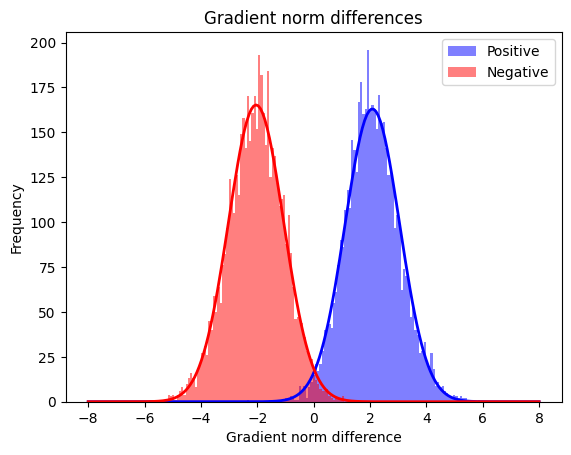

In [23]:
num_bins = 200
x_range = 8
x = np.linspace(-x_range, x_range, num_bins)
bin_size = 2*x_range/num_bins

positive_differences = differences[indeces == 1, :]
mu_pos, std_pos = norm.fit(positive_differences)
p_pos = norm.pdf(x, mu_pos, std_pos)*positive_differences.size*bin_size

negative_differences = differences[indeces == 0, :]
mu_neg, std_neg = norm.fit(negative_differences)
p_neg = norm.pdf(x, mu_neg, std_neg)*negative_differences.size*bin_size

plt.hist(positive_differences, bins=x, alpha=0.5, label='Positive', color='b')
plt.hist(negative_differences, bins=x, alpha=0.5, label='Negative', color='r')
plt.plot(x, p_pos, 'b', linewidth=2)
plt.plot(x, p_neg, 'r', linewidth=2)
plt.title("Gradient norm differences")
plt.xlabel("Gradient norm difference")
plt.ylabel("Frequency")
plt.legend(loc='upper right')
plt.show()

# 4. Membefship inference from predictions

## Special sampling functions

In [24]:
# A function that samples neighboring datasets, where the label in the second quadrant is always 0, in the fourth quadrant is always 1, and in the other two quadrants is sampled from a Bernoulli distribution with probability 0.5.
# The two datasets have one additional data point, which is the same in both datasets, and is located at the point (clipping_radius, clipping_radius), with the label 0 in the first dataset and 1 in the second dataset.
# data_parameters: a dictionary containing the data sampling parameters
# learning_parameters: a dictionary containing the learning parameters
def sample_neighboring_datasets(data_parameters, learning_parameters):
    dim = 2
    mean = np.zeros(dim)
    data = np.random.normal(mean, data_parameters['data_scale'], (data_parameters['training_sample_size'], dim))
    labels = np.random.binomial(1, 0.5, data_parameters['training_sample_size'])    
    labels[(data[:, 0] <= 0) & (data[:, 1] <= 0)] = 0
    labels[(data[:, 0] > 0) & (data[:, 1] > 0)] = 1
    data_point = np.array([1, 1])*learning_parameters['clipping_radius']
    data_0 = np.append(data, [data_point], axis=0)
    data_1 = np.append(data, [data_point], axis=0)
    labels_0 = np.append(labels, 0)
    labels_1 = np.append(labels, 1)
    return [{'data': data_0, 'labels': labels_0}, {'data': data_1, 'labels': labels_1}]

## Membership inference function

In [25]:
# A function that computes the returns the probability of the label 1 for the data point guess_model based on a given model
# guess_model: the data point that is equal to the guess model
# model: the model
def prediction_membership_inference_test(guess_model, model):
    return np.clip(1/(1+np.exp(-np.dot(guess_model, model))), 1e-6, 1-1e-6)

## Experiment functions

In [26]:
# A single prediction based membership inference experiment, which samples the data and the model using the special function, and then computes the probability of the label 1 for the data point guess_model based on the model
# data_parameters: a dictionary containing the data sampling parameters
# learning_parameters_array: an array of dictionaries, each containing a set of learning parameters
def run_prediction_MI_experiment(data_parameters, learning_parameters_array):
    guess_model = np.array([1.0, 1.0])
    keys = [learning_parameters['name'] for learning_parameters in learning_parameters_array]
    index = np.random.binomial(1, 0.5)
    probabilities = np.zeros(len(keys))
    for i in range(len(keys)):
        learning_parameters = learning_parameters_array[i]
        training_sets = sample_neighboring_datasets(data_parameters, learning_parameters)
        models_array = logistic_regression(guess_model, training_sets[index], learning_parameters)
        model = models_array[-1]
        probabilities[i] = prediction_membership_inference_test(guess_model, model)
    return index, probabilities

# A full prediction based membership inference experiment, which runs num_of_experiments experiments using the previous function and averages the probabilities
# data_parameters: a dictionary containing the data sampling parameters
# learning_parameters_array: an array of dictionaries, each containing a set of learning parameters
def run_full_prediction_MI_experiment(data_parameters, learning_parameters_array, num_of_experiments):
    keys = [learning_parameters['name'] for learning_parameters in learning_parameters_array]
    indeces = np.zeros(num_of_experiments)
    probabilities = np.zeros((num_of_experiments, len(keys)))
    for i in range(num_of_experiments):
        indeces[i], probabilities[i, :] = run_prediction_MI_experiment(data_parameters, learning_parameters_array)
    return indeces, probabilities

## Experiment 4

In [27]:
data_parameters = {'data_scale': 2, 'training_sample_size': 40, 'test_ratio': 0.5}
learning_parameters_array = [{'name': 'Learned - noisy (0.01)', 'learning_rate': 1, 'num_of_iterations': 100, 'clipping_radius': data_parameters['data_scale']*4, 'noise_factor': 0.0001}]
num_of_experiments = 10000

In [28]:
indeces, probabilities = run_full_prediction_MI_experiment(data_parameters, learning_parameters_array, num_of_experiments)

Positive: mu =  0.7937909764721354 , std =  0.07236927638712849
Negative: mu =  0.6495067964653373 , std =  0.046612155231632695


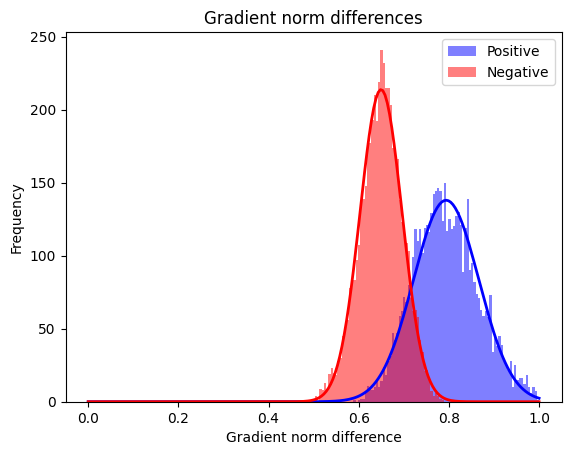

In [29]:
num_bins = 200
x = np.linspace(0, 1, num_bins)

positive_probabilities = probabilities[indeces == 1, :]
mu_pos, std_pos = norm.fit(positive_probabilities)
p_pos = norm.pdf(x, mu_pos, std_pos)*positive_probabilities.size/num_bins

negative_probabilities = probabilities[indeces == 0, :]
mu_neg, std_neg = norm.fit(negative_probabilities)
p_neg = norm.pdf(x, mu_neg, std_neg)*negative_probabilities.size/num_bins

print("Positive: mu = ", mu_pos, ", std = ", std_pos)
print("Negative: mu = ", mu_neg, ", std = ", std_neg)
plt.hist(positive_probabilities, bins=x, alpha=0.5, label='Positive', color='b')
plt.hist(negative_probabilities, bins=x, alpha=0.5, label='Negative', color='r')
plt.plot(x, p_pos, 'b', linewidth=2)
plt.plot(x, p_neg, 'r', linewidth=2)
plt.title("Gradient norm differences")
plt.xlabel("Gradient norm difference")
plt.ylabel("Frequency")
plt.legend(loc='upper right')
plt.show()